# Freesound Audio Tagging 2019

![Logo](https://storage.googleapis.com/kaggle-competitions/kaggle/10700/logos/header.png)

Thank you for all the competitors, kaggle teams, and the host of this competition!  
We enjoyed a lot during the competition and learned many things.  

None of us had experience with audio data, and we also didn't get used to use Nerual Networks.  
We especially want to thank [@daisukelab](https://www.kaggle.com/daisukelab) for his clear instruction with great kernels and datasets, [@mhiro2](https://www.kaggle.com/mhiro2) for sharing excellent training framework, and [@sailorwei](https://www.kaggle.com/sailorwei) for showing his Inception v3 model in his public kernel. We were helped a lot with public kernels below shared by them.

https://www.kaggle.com/daisukelab/cnn-2d-basic-solution-powered-by-fast-ai  
https://www.kaggle.com/mhiro2/simple-2d-cnn-classifier-with-pytorch  
https://www.kaggle.com/sailorwei/fat2019-2d-cnn-with-mixup-lb-0-673

We've created a kernel to explain team [kaggler-ja] Shirogane's solution.

In short, our solution is 3 models ensemble, one is **Custom CNN** and the other two are **Inception v3** models.  
We used **Log-Melspectrogram** features made with the manner introduced by @daisukelab in his great dataset.

https://www.kaggle.com/daisukelab/fat2019_prep_mels1  

We used noisy data for **warm-up**, just like pre-training the model, and curated data for **fine-tuning** the model, which was trained in earlier stage with noisy data.

**All the works for this competition were done with kaggle kernels**, and we'd like to thank a lot to kaggle for giving us great opportunities and computing resources.

## Contents

1. [Data Augmentation](#Data_Augmentation)
  - [pitch shift](#pitch_shift)
  - [fade](#Fade)
  - [reverb](#Reverb)
  - [treble and bass](#Treble_and_Bass)
  - [equalizing](#Equalizing)
2. [Crop Policy](#Crop_Policy)
  - [Uniform Crop](#Uniform_Crop)
  - [Strength Adaptive Crop](#Strength_Adaptive_Crop)
3. [Model Structure](#Model_Structure)
  - [Custom CNN](#Custom_CNN)
  - [Inception v3](#Inception_v3)
4. [Augmentation in Batch](#Augmentation_in_Batch)
  - [blend image augmentation](#blend_image_augmentation)
5. [Training Strategy](#Training_Strategy)
  - [Pretrain with Noisy Data](#Pretrain_with_Noisy_Data)
  - [Training with Curated Data](#Training_with_Curated_Data)
  - [TTA for Validation](#TTA_for_Validation)
6. [Ensemble](#Ensemble)

## Data Augmentation

We created augmented training dataset with [sox](http://sox.sourceforge.net/).  
Sox is an open-source synthesis tool, which is easy to use from command line interface, and is installed to Kaggle kernel by default.

We can use sox like this.

In [1]:
!sox ../input/freesound-audio-tagging-2019/train_curated/004ca909.wav output.wav pitch "-500" gain -h

Now check the result of audio transformation.

In [2]:
import gc
import random
import IPython.display

import subprocess as sp

import librosa
import librosa.display

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from PIL import Image, ImageOps
from torch.utils.data import Dataset

from pathlib import Path
from tqdm import tqdm_notebook

from fastprogress import master_bar, progress_bar

In [3]:
def read_audio(conf, pathname, trim_long_data):
    y, sr = librosa.load(pathname, sr=conf.sampling_rate)
    if 0 < len(y):
        y, _ = librosa.effects.trim(y)

    if len(y) > conf.samples:
        if trim_long_data:
            y = y[0:0+conf.samples]
    else:
        padding = conf.samples - len(y)
        offset = padding // 2
        y = np.pad(y, (offset, conf.samples - len(y) - offset), conf.padmode)
    return y


def audio_to_melspectrogram(conf, audio):
    spectrogram = librosa.feature.melspectrogram(audio, 
                                                 sr=conf.sampling_rate,
                                                 n_mels=conf.n_mels,
                                                 hop_length=conf.hop_length,
                                                 n_fft=conf.n_fft,
                                                 fmin=conf.fmin,
                                                 fmax=conf.fmax)
    spectrogram = librosa.power_to_db(spectrogram)
    spectrogram = spectrogram.astype(np.float32)
    return spectrogram


def show_melspectrogram(conf, mels, title='Log-frequency power spectrogram'):
    librosa.display.specshow(mels, x_axis='time', y_axis='mel', 
                             sr=conf.sampling_rate, hop_length=conf.hop_length,
                            fmin=conf.fmin, fmax=conf.fmax)
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.show()


def read_as_melspectrogram(conf, pathname, trim_long_data, debug_display=False):
    x = read_audio(conf, pathname, trim_long_data)
    mels = audio_to_melspectrogram(conf, x)
    if debug_display:
        IPython.display.display(IPython.display.Audio(x, rate=conf.sampling_rate))
        show_melspectrogram(conf, mels)
    return mels


class conf:
    sampling_rate = 44100
    duration = 2 # sec
    hop_length = 347*duration # to make time steps 128
    fmin = 20
    fmax = sampling_rate // 2
    n_mels = 128
    n_fft = n_mels * 20
    padmode = 'constant'
    samples = sampling_rate * duration

The original audio data and its melspectrogram representation are below.

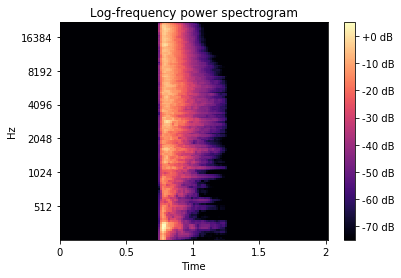

In [4]:
curated_dir = Path("../input/freesound-audio-tagging-2019/train_curated")
read_as_melspectrogram(
    conf=conf, 
    debug_display=True, 
    trim_long_data=False, 
    pathname=curated_dir / "004ca909.wav");

And the transformed audio data is like this.

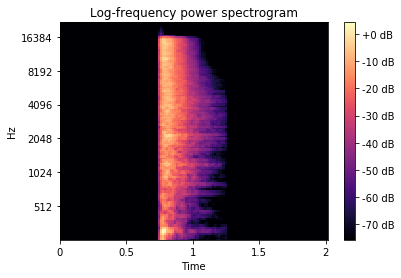

In [5]:
read_as_melspectrogram(
    conf=conf, 
    debug_display=True, 
    trim_long_data=False, 
    pathname="output.wav");

We used sox from Python using `subprocess` package and created augmented features with kaggle kernels.
Here's one of the kernel which created some of the augmented features with `train_curated` dataset.

https://www.kaggle.com/hidehisaarai1213/freesound-sox-pitch-fade-reverb-treble-bas

We created 7 augmented datasets whose size are 4970 each, which means the same size as curated one.  
Here's the types of augmentation.  
We used those augmentation which certainly alter what it sounds like but still can be recoginized as the same class.

### pitch shift

This augmentation changes the pitch of the sound.  
We applied both pitch-up and pitch-down.  
The degree of pitch shift was fixed to 500 cent.

In [6]:
def show_before_and_after(conf, 
                          mels1, 
                          mels2, 
                          title="Log-melspectrogram comparison"):
    fig, (axL, axR) = plt.subplots(ncols=2, figsize=(15,4), sharex=True)
    plt.title(title)
    plt.subplot(1, 2, 1)
    librosa.display.specshow(mels1, x_axis='time', y_axis='mel', 
                             sr=conf.sampling_rate, hop_length=conf.hop_length,
                             fmin=conf.fmin, fmax=conf.fmax)
    axL.set_title("original")
    plt.colorbar(format='%+2.0f dB')
    
    plt.subplot(1, 2, 2)
    librosa.display.specshow(mels2, x_axis='time', y_axis='mel', 
                             sr=conf.sampling_rate, hop_length=conf.hop_length,
                             fmin=conf.fmin, fmax=conf.fmax)
    axR.set_title("transformed")
    plt.colorbar(format='%+2.0f dB')
    plt.show()


def transform_and_compare(conf, pathname: Path, cmd=[]):
    x = read_audio(conf, pathname, trim_long_data=False)
    mels = audio_to_melspectrogram(conf, x)        
    IPython.display.display(IPython.display.Audio(x, rate=conf.sampling_rate))

    cmd = ["sox", str(pathname), "output.wav"] + cmd
    sp.run(cmd)

    augmented = read_audio(conf, Path("output.wav"), trim_long_data=False)
    mels_augmented = audio_to_melspectrogram(conf, augmented)
    IPython.display.display(IPython.display.Audio(augmented, rate=conf.sampling_rate))

    show_before_and_after(conf, mels, mels_augmented)
    return mels, mels_augmented

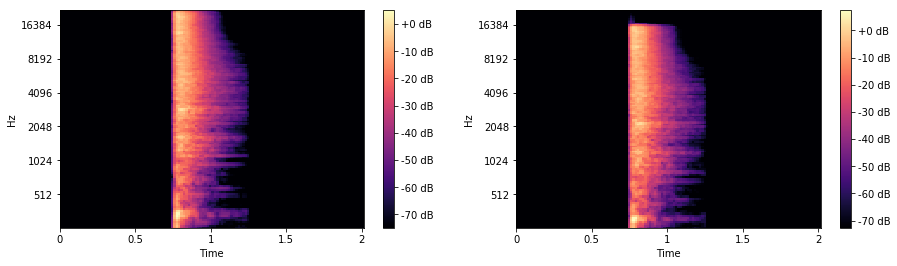

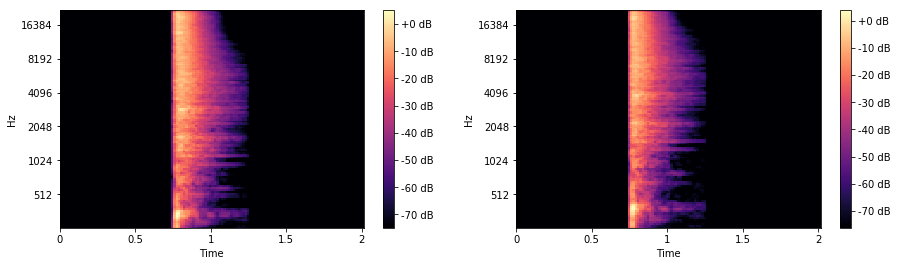

In [7]:
# 500 cent pitch-down
transform_and_compare(conf, curated_dir / "004ca909.wav", cmd=["pitch", "-500"])

# 500 cent pitch-up
transform_and_compare(conf, curated_dir / "004ca909.wav", cmd=["pitch", "+500"]);

### Fade

This augmentation alter the volume of the sound.   

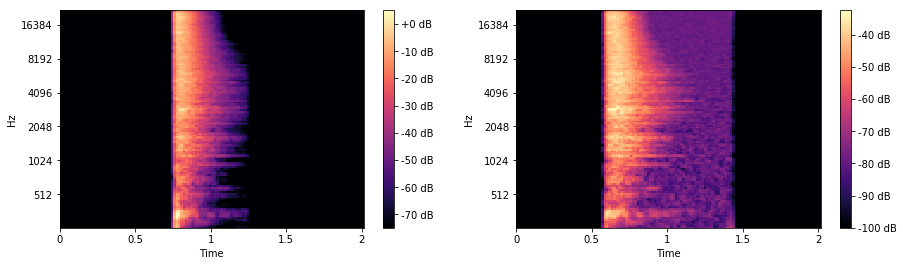

In [8]:
# fade in and out cyclically
transform_and_compare(conf, curated_dir / "004ca909.wav", cmd=["fade", "q", "3"]);

### Reverb

This augmentation add reverberation to the original sound.

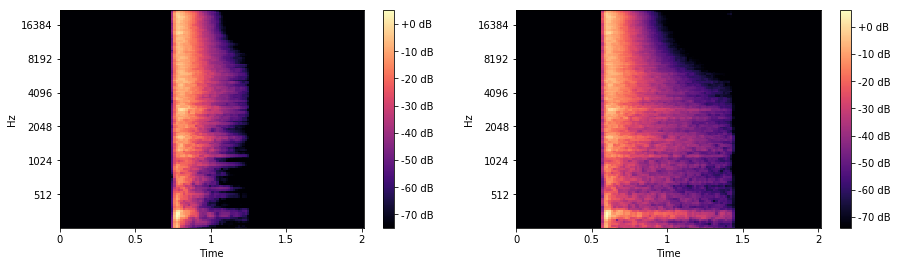

In [9]:
transform_and_compare(conf, curated_dir / "004ca909.wav", cmd=["reverb"]);

### Treble and Bass

This augmentation emphasize or weaken treble and bass range of the sound.

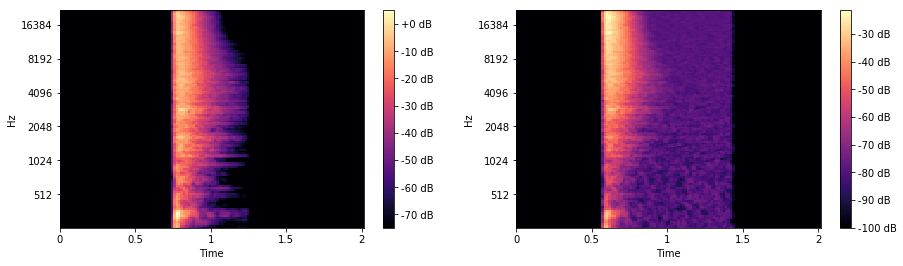

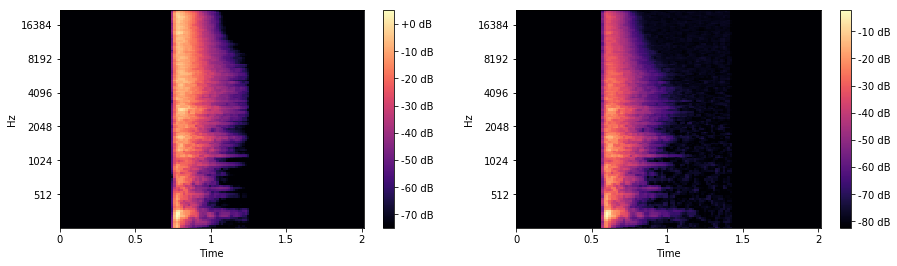

In [10]:
# emphasize
transform_and_compare(conf, curated_dir / "004ca909.wav", cmd=["gain", "-h", "treble", "+20", "bass", "+20"]);

# weaken
transform_and_compare(conf, curated_dir / "004ca909.wav", cmd=["gain", "-h", "treble", "-30", "bass", "-30"]);

### Equalizing

This augmentation adjust custom frequency range.

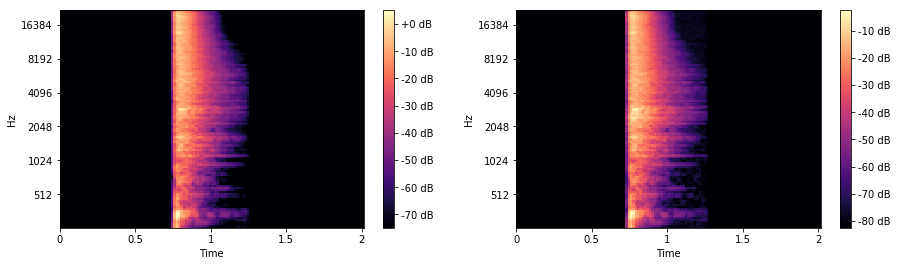

In [11]:
transform_and_compare(conf, curated_dir / "004ca909.wav", cmd=["gain", "-h", "equalizer", "2400", "3q", "8"]);

We applied these augmentations to the whole curated data.  
When we train the model with curated data, we used all of these augmented features, so the size of the train dataset was 8 times larger(7 augmentations + 1 original) than the original curated dataset.

We also applied pitch shift to the noisy data.

In [12]:
gc.collect()

59158

Here's the table which summarize how much each augmentation worked on the score.  
Note that this score was calcurated with Custom CNN model, and **the effect of the augmentation varies between models**.

|score \ augmentation|no aug| pitch down | pitch up | fade | reverb | treble and bass down | treble and bass up | equalize | pitch down, fade, reverb, treble and bass down| all|
|---|---|---|---|---|---|---|---|---|---|
|CV(no warm-up)|0.800|0.809|0.805|0.805|0.801|0.809|0.808|0.803|**0.829**|0.825|
|CV(warm-up)|-|-|-|-|-|-|-|-|0.87+|**0.88**|
|LB|0.690|-|-|-|-|-|-|-|0.720|**0.72x(better than 0.720)**|

We didn't checked all the score improvement of Inception v3 model with these augmentation, but **between no aug and with aug, there exist around 0.001 improvement**.

|score\augmentation|no aug(no warm-up)|pitch down, fade, reverb, treble and bass down(no warm-up)|pitch down, fade, reverb, treble and bass down| all|
|---|---|---|---|---|
|CV|we don't remember|0.85|0.87|**0.87+**|
|LB|0.699?|0.713|0.725|**0.725+**|

## Crop Policy

### Uniform Crop

We use random crop, because we use fixed image size(128 * 128). Random crop got a little better cv than the first 2 seconds cropped. At first, it wa cropped uniformly as mhiro's kernel.

### Strength Adaptive Crop

Many sound crip has important information at the first few seconds. Some sample has it in the middle of crip. However, due to the nature of recording, it is rare to have important information at th end of sounds. The score drops about 0.03~0.04 when learning only the last few seconds.

Then, We introduce Strength Adaptive Crop. We tried to crop the place where the total of db is high preferentially.

This method is very effective because most samples contain important information in places where the sound is loud.

CV 0.01 up
LB 0.004~0.005 up

In [13]:
def _get_strength(x):
    strength_list_train = []
    time_dim, base_dim = x.shape[1], x.shape[0]
    x_sum = []
    x_max = 0
    x_min = np.inf
    for j in range(0,time_dim-base_dim + 1):
        #x_temp = x[:,j:j + base_dim].sum()
        x_temp = x[0:84,j:j + base_dim].sum()
        x_sum.append(x_temp)
        if x_temp > x_max:
            x_max = x_temp
        if x_temp < x_min:
            x_min = x_temp
    if (x_max == x_min):
        height = x_max
    else:
        height = x_max - x_min
    strength_list_train.append([x_sum, height, x_max, x_min, time_dim, base_dim])
    return strength_list_train

#strength_list_train = _get_strength_list(x_train)
def mono_to_color(X, mean=None, std=None, norm_max=None, norm_min=None, eps=1e-6):
    # Stack X as [X,X,X]

    # Standardize
    mean = mean or X.mean()
    X = X - mean
    std = std or X.std()
    Xstd = X / (std + eps)
    _min, _max = Xstd.min(), Xstd.max()
    norm_max = norm_max or _max
    norm_min = norm_min or _min
    if (_max - _min) > eps:
        # Normalize to [0, 255]
        V = Xstd
        V[V < norm_min] = norm_min
        V[V > norm_max] = norm_max
        V = 255 * (V - norm_min) / (norm_max - norm_min)
        V = V.astype(np.uint8)
    else:
        # Just zero
        V = np.zeros_like(Xstd, dtype=np.uint8)
    return V

def convert_wav_to_image(df, source):
    X = []
    for i, row in tqdm_notebook(df.iterrows()):
        x = read_as_melspectrogram(conf, source/str(row.fname), trim_long_data=False)
        x_color = mono_to_color(x)
        X.append(x_color)
    return X

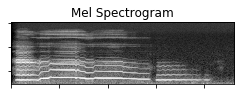

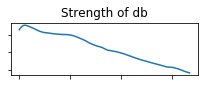

In [14]:
sample_x = read_as_melspectrogram(
    conf=conf, 
    debug_display=False, 
    trim_long_data=False, 
    pathname=curated_dir / "0164cba5.wav");
sample_x = mono_to_color(sample_x)
image = Image.fromarray(sample_x)
im_flip = ImageOps.flip(image)

plt.figure(figsize=(4, 2))
plt.title('Mel Spectrogram')
plt.imshow(im_flip)
plt.tick_params(labelleft=False, labelbottom=False)
strength_list = _get_strength(sample_x)
plt.figure(figsize=(3, 1.3))
plt.title('Strength of db')
plt.plot(strength_list[0][0])
plt.tick_params(labelleft=False, labelbottom=False)
plt.tight_layout()

This sample has important information earlier, but there is a little information from the end of sound.

We prepare strength_list in advance and apply strength adaptive crop in FATTrainDataset.Here the code.

In [15]:
def _get_strength_list(x_train):
    strength_list_train = []
    for i in range(len(x_train)):
        time_dim, base_dim = x_train[i].shape[1], x_train[i].shape[0]
        x = x_train[i]
        x_sum = []
        x_max = 0
        x_min = np.inf
        for j in range(0,time_dim-base_dim + 1):
            #x_temp = x[:,j:j + base_dim].sum()
            x_temp = x[0:84,j:j + base_dim].sum()
            x_sum.append(x_temp)
            if x_temp > x_max:
                x_max = x_temp
            if x_temp < x_min:
                x_min = x_temp
        if (x_max == x_min):
            height = x_max
        else:
            height = x_max - x_min
        strength_list_train.append([x_sum, height, x_max, x_min, time_dim, base_dim])
    return strength_list_train

#strength_list_train = _get_strength_list(x_train)

In [16]:
class FATTrainDataset(Dataset):
    def __init__(self, mels, labels, transforms, strength_list):
        super().__init__()
        self.mels = mels
        self.labels = labels
        self.transforms = transforms
        self.strength_list = strength_list

        
    def __len__(self):
        return len(self.mels)
    
    def __getitem__(self, idx):      
        x = self.mels[idx]
        x_sum = self.strength_list[idx][0]
        height = self.strength_list[idx][1]
        x_max = self.strength_list[idx][2]
        x_min = self.strength_list[idx][3]
        time_dim = self.strength_list[idx][4]
        base_dim = self.strength_list[idx][5]
        flag = True
        while flag:
            crop = random.randint(0, int(height * (time_dim- base_dim)))
            # all 0
            if height == 0:
                crop_idx = 0
                value = 0
            else:
                crop_idx = int(crop // height)
                value = int(crop % height)                
            if ((x_sum[crop_idx] - x_min) - value) >= 0:
                flag = False
        crop = crop_idx

        image = Image.fromarray(x, mode='RGB') 
        image = image.crop([crop, 0, crop + base_dim, base_dim])
        image = self.transforms(image).div_(255)
        
        label = self.labels[idx]
        label = torch.from_numpy(label).float()
        
        return image, label

## Model Structure

### Custom CNN

At first, we worked a lot on our custom CNN model. We started from improving [CVSSP Baseline](https://www.kaggle.com/c/freesound-audio-tagging-2019/discussion/89382#latest-534349).   
We changed kernel size, number of Convolution Blocks, **Pooling policy**, and the **structure of the fully connected layer**. We also added **spatial and channel attention**.  
The original CVSSP Baseline model structure is below.

In [17]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        
        super(ConvBlock, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=in_channels, 
                              out_channels=out_channels,
                              kernel_size=(3, 3), stride=(1, 1),
                              padding=(1, 1), bias=False)
                              
        self.conv2 = nn.Conv2d(in_channels=out_channels, 
                              out_channels=out_channels,
                              kernel_size=(3, 3), stride=(1, 1),
                              padding=(1, 1), bias=False)
                              
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.init_weights()
        
    def init_weights(self):
        
        init_layer(self.conv1)
        init_layer(self.conv2)
        init_bn(self.bn1)
        init_bn(self.bn2)
        
    def forward(self, input, pool_size=(2, 2), pool_type='avg'):
        
        x = input
        x = F.relu_(self.bn1(self.conv1(x)))
        x = F.relu_(self.bn2(self.conv2(x)))
        if pool_type == 'max':
            x = F.max_pool2d(x, kernel_size=pool_size)
        elif pool_type == 'avg':
            x = F.avg_pool2d(x, kernel_size=pool_size)
        else:
            raise Exception('Incorrect argument!')
        
        return x
    
    
class Cnn_9layers_AvgPooling(nn.Module):
    
    def __init__(self, classes_num):
        super(Cnn_9layers_AvgPooling, self).__init__()

        self.conv_block1 = ConvBlock(in_channels=1, out_channels=64)
        self.conv_block2 = ConvBlock(in_channels=64, out_channels=128)
        self.conv_block3 = ConvBlock(in_channels=128, out_channels=256)
        self.conv_block4 = ConvBlock(in_channels=256, out_channels=512)

        self.fc = nn.Linear(512, classes_num, bias=True)

        self.init_weights()

    def init_weights(self):

        init_layer(self.fc)

    def forward(self, input):
        '''
        Input: (batch_size, times_steps, freq_bins)'''
        
        x = input[:, None, :, :]
        '''(batch_size, 1, times_steps, freq_bins)'''
        
        x = self.conv_block1(x, pool_size=(2, 2), pool_type='avg')
        x = self.conv_block2(x, pool_size=(2, 2), pool_type='avg')
        x = self.conv_block3(x, pool_size=(2, 2), pool_type='avg')
        x = self.conv_block4(x, pool_size=(1, 1), pool_type='avg')
        '''(batch_size, feature_maps, time_steps, freq_bins)'''
        
        x = torch.mean(x, dim=3)        # (batch_size, feature_maps, time_stpes)
        (x, _) = torch.max(x, dim=2)    # (batch_size, feature_maps)
        output = torch.sigmoid(self.fc(x))
        
        return output

We altered the model structure like the model below.

In [18]:
# Attention Layers
class SpatialAttention2d(nn.Module):
    def __init__(self, channel):
        super(SpatialAttention2d, self).__init__()
        self.squeeze = nn.Conv2d(channel, 1, kernel_size=1, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        z = self.squeeze(x)
        z = self.sigmoid(z)
        return x * z


class GAB(nn.Module):
    def __init__(self, input_dim, reduction=4):
        super(GAB, self).__init__()
        self.global_avgpool = nn.AdaptiveAvgPool2d(1)
        self.conv1 = nn.Conv2d(input_dim, input_dim // reduction, kernel_size=1, stride=1)
        self.conv2 = nn.Conv2d(input_dim // reduction, input_dim, kernel_size=1, stride=1)
        self.relu = nn.ReLU(inplace=True)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        z = self.global_avgpool(x)
        z = self.relu(self.conv1(z))
        z = self.sigmoid(self.conv2(z))
        return x * z

    
class SCse(nn.Module):
    def __init__(self, dim):
        super(SCse, self).__init__()
        self.satt = SpatialAttention2d(dim)
        self.catt = GAB(dim)

    def forward(self, x):
        return self.satt(x) + self.catt(x)

We borrowed nice implementation from https://github.com/ybabakhin/kaggle_salt_bes_phalanx.  
We'd like to appreciate to [@phalanx](https://www.kaggle.com/phalanx) for these implementations.

We added some modification in the ConvBlock and the model structure.  
Here's our model.

In [19]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, reduction=16):
        super(ConvBlock, self).__init__()
        # changed kernel size
        # we don't know why, but this is better than (3, 3) kernels.
        self.conv1 = nn.Conv2d(in_channels=in_channels,
                               out_channels=out_channels,
                               kernel_size=(2, 2),
                               stride=(1, 1),
                               padding=(1, 1),
                               bias=False)
        self.conv2 = nn.Conv2d(in_channels=out_channels,
                               out_channels=out_channels,
                               kernel_size=(2, 2),
                               stride=(1, 1),
                               padding=(1, 1),
                               bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # Spatial and Channel Squeeze and Exitation
        self.scse = SCse(out_channels)
        
        self.init_weights()
        
    def init_weights(self):
        init_layer(self.conv1)
        init_layer(self.conv2)
        init_bn(self.bn1)
        init_bn(self.bn2)
        
    def forward(self, inp, pool_size=(2, 2), pool_type="avg"):
        x = inp
        x = F.relu_(self.bn1(self.conv1(x)))
        x = F.relu_(self.scse(self.bn2(self.conv2(x))))
        if pool_type == "max":
            x = F.max_pool2d(x, kernel_size=pool_size)
        elif pool_type == "avg":
            x = F.avg_pool2d(x, kernel_size=pool_size)
        # Added 'both' pool.
        elif pool_type == "both":
            x1 = F.max_pool2d(x, kernel_size=pool_size)
            x2 = F.avg_pool2d(x, kernel_size=pool_size)
            x = x1 + x2
        else:
            import pdb
            pdb.set_trace()
        return x
    
    
class ConvNet(nn.Module):
    def __init__(self, n_classes=80):
        super(ConvNet, self).__init__()
        # 5 ConvBlocks
        self.conv1 = ConvBlock(1, 32)
        self.conv2 = ConvBlock(32, 64)
        self.conv3 = ConvBlock(64, 128)
        self.conv4 = ConvBlock(128, 256)
        self.conv5 = ConvBlock(256, 512)
        
        self.bn1 = nn.BatchNorm1d((1 + 4 + 20) * 512)
        self.drop1 = nn.Dropout(0.4)
        self.fc1 = nn.Linear((1 + 4 + 20) * 512, 512)
        self.prelu = nn.PReLU()
        self.bn2 = nn.BatchNorm1d(512)
        self.drop2 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(512, n_classes)
        
    def init_weight(self):
        init_layer(self.fc1)
        init_layer(self.fc2)
        init_bn(self.bn1)
        init_bn(self.bn2)
    
    def forward(self, x):
        x = x.view(x.size(0), 1, x.size(1), x.size(2))
        # Changed pooling policy.
        x = self.conv1(x, pool_size=(1, 1), pool_type="both")
        x = self.conv2(x, pool_size=(4, 1), pool_type="both")
        x = self.conv3(x, pool_size=(1, 3), pool_type="both")
        x = self.conv4(x, pool_size=(4, 1), pool_type="both")
        x = self.conv5(x, pool_size=(1, 3), pool_type="both")
        
        # Cutting the feature map to arbitrary size.
        x1_max = F.max_pool2d(x, (5, 8))
        x1_mean = F.avg_pool2d(x, (5, 8))
        x1 = (x1_max + x1_mean).reshape(x.size(0), -1)
        
        x2_max = F.max_pool2d(x, (2, 4))
        x2_mean = F.avg_pool2d(x, (2, 4))
        x2 = (x2_max + x2_mean).reshape(x.size(0), -1)
        
        x = torch.mean(x, dim=3)
        x, _ = torch.max(x, dim=2)
        
        x = torch.cat([x, x1, x2], dim=1)
        x = self.drop1(self.bn1(x))
        x = self.prelu(self.fc1(x))
        x = self.drop2(self.bn2(x))
        x = self.fc2(x)
         
        return x

The difference from the original model is...

#### kernel size

We don't know why, but the size (2, 2) was the best.

#### The nuber of convolution blocks

We used 5 blocks to get 512 channels feature map. This is because we designed our model considering the meaning of each blocks (,although we're not sure whether it is working as we imaged originally).  
We found [@omalleyt](https://www.kaggle.com/omalleyt)'s 2nd place solution for Tensorflow Speech Recognition Competition very helpful.  
https://www.kaggle.com/c/tensorflow-speech-recognition-challenge/forums/t/47715/2nd-place-solution?forumMessageId=270205#post270205

The *design philosophy* behind the placement of convolution blocks are as follows.

  - First Convolution Block: channel 1 -> 32, no pooling.  
    We put this block to collect primitive patterns of the log-melspectrogram.
  - Second Convolution Block: channel 32 -> 64, (4, 1) pooling.  
    Clearly, **spectrogram has different axis, and we need to treat them separately**. We took careful **not to aggregate the feature map along to the time axis and to the frequency axis simultaneously**. In this block, we'll get the primitive patterns connected to the patterns nearby in the time axis.
  - Third Convolution Block: channel 64 -> 128, (1, 3) pooling.  
    In this block, we'll get the primitive pattens connected in the frequency axis.
  - Fourth Convolution Block: channel 128 -> 256, (4, 1) pooling.  
    This block allows patterns to move in the time axis.
  - Fifth Convolution Block: channel 256 -> 512, (1, 3) pooling.  
    As explained in this [blog post](https://t.co/IgUKfFOYaa), moving the pattern in the frequency can be problematic. But that isn't the case when the degree of the translation is not so big. This block allows patterns to move in the frequency axis a little.
    
#### Cutting output feature map to arbitrary size

We found that the position in the feature map is important when treating spectrogram.  
The same pattern at the bottom of the image and at the top of the image are totally different. We should not allow patterns translate along the frequency axis. That is a little bit different from treating natural images.

To treat the position in the feature map, we used **[spatial pyramid pooling](https://arxiv.org/pdf/1406.4729.pdf)** to catch the local features.  
With this trick, CV lwlrap score improved **0.015 - 0.03**.

### Inception v3

We used two Inception v3 models. One is all the same as the original Inception v3 architecture, so we simply used the one in `torchvision.models` package. The other one was 1ch version of the original Inception v3, so we just simply altered the first layer.  
The score of the 1ch version was not as stable as 3ch version, but we found that model a little bit different from the original one.  

## Augmentation in Batch

### blend image augmentation

We used below augmentation strategy in batch

https://pillow.readthedocs.io/en/stable/reference/Image.html

In [20]:
import os
import pickle
from PIL import Image

def array2img(array):    
    image = Image.fromarray(array, mode='RGB')        
    time_dim, base_dim = image.size
    crop = random.randint(0, time_dim - base_dim)
    image = image.crop([crop, 0, crop + base_dim, base_dim])
    return image

In [21]:
with open(Path('../input/fat2019_prep_mels1') / 'mels_train_curated.pkl', 'rb') as curated:
    x_train = pickle.load(curated)
    
print(x_train[0].shape)

(128, 448, 3)


In [22]:
im1 = array2img(x_train[0])
im2 = array2img(x_train[1])

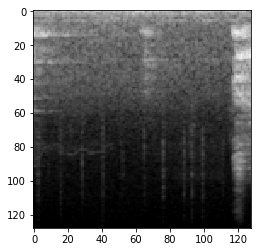

In [23]:
plt.imshow(im1);

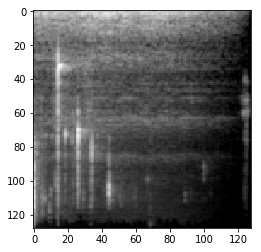

In [24]:
plt.imshow(im2);

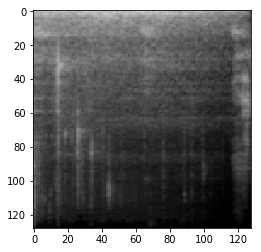

In [25]:
lam = np.random.beta(1.0, 1.0)

img_blend = Image.blend(im1=im1, im2=im2, alpha=lam)
plt.imshow(img_blend);

So, We got mixed Image data

We define below function to apply to above strategy in our training

In [26]:
def _get_blend_arr(x_trn, y_trn, lam = np.random.beta(1.0, 1.0)):
    # get mix data
    blend_arr_x = []
    blend_arr_y = []
    for i in range(1000):
        r1, r2 = random.randint(0, len(x_trn)-1), random.randint(0, len(x_trn)-1)
        
        img0 = array2img(x_trn[r1])
        img1 = array2img(x_trn[r2])
        img_blend = Image.blend(im1=img0, im2=img1, alpha=lam)

        y_blend = y_trn[r1]*(1-lam) + y_trn[r2]*lam
        img_blend_arr = np.asarray(img_blend)
        blend_arr_x.append(img_blend_arr)
        blend_arr_y.append(y_blend)    
    idx_ex = np.arange(len(blend_arr_x))
    return blend_arr_x, blend_arr_y, idx_ex

# blend_arr_x, blend_arr_y, idx_ex = _get_blend_arr(x_trn, y_trn, lam = np.random.beta(1.0, 1.0))

## Training Strategy

This is our pipline.

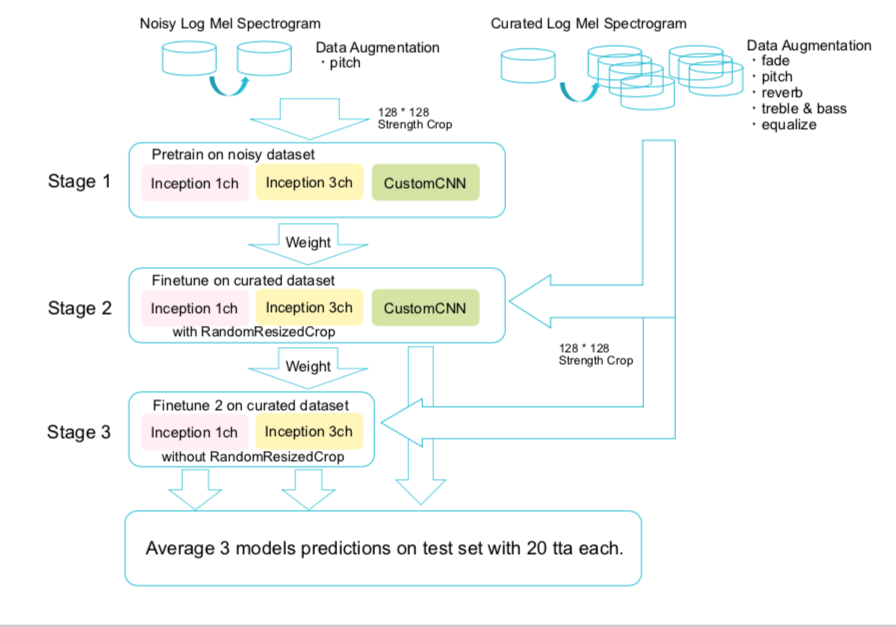

In [27]:
from IPython.display import Image
Image("../input/freesound-solution-pic/Freesound_solution_pic1.png")

### Pretrain with Noisy Data

We used noisy data to 'pre-train' our model.  
We had two policy to train and validate with noisy data.  
You can see how we did this in [this kernel](https://www.kaggle.com/hidehisaarai1213/convnet-noisy-all-pitch-pretraining).

1. Train with all the noisy data, validate with curated data.
2. Split noisy data with `train_test_split`. Both train and validate are done with only noisy data.

We tried both policy, and found it surprising that policy 2 was slightly better than policy 1. We believe it was just a seed magic, but the model trained with policy12 were at least as better as the model trained with policy1.  

We used [@mhiro2's way](https://www.kaggle.com/mhiro2/simple-2d-cnn-classifier-with-pytorch) to train, which means 

- change learning rate with CosineAnnealingLR cyclickally in the range between 1e-3 and 1e-5. The cycle was 10 epochs.
- use Adam optimizer.
- optimize BCEWithLogitLoss

We also used augmented data in this stage.  
We created a `pitch` augmented dataset from train_noisy dataset and used it only for training.  
We only used train_noisy dataset for validation.

In the pre-training of Inception models, we applied RandomResizedCrop to the data, and it required us to train longer, so we introduced stage 2 pre-training.  
In the stage2 pre-training, we didn't changed any settings except for the initial weight of the network.

With pre-training, local lwlrap jumped from **0.83 to 0.88** with Custom CNN, and **0.86 to 0.87** with Inception v3.  
Unfortunately, we don't know how much the LB lwlrap score improved with Custom CNN, but the LB lwlrap score of Inception v3 improved **0.01** with this trick.

### Training with Curated Data

We used curated data to 'finetune' the models, which were 'pre-trained' with noisy data.  
We used augmented dataset with original train_curated dataset, which made the whole training dataset 8 times larger than the original one.  

We used normal `KFold` to get cross validation, and split the dataset into 5 subsets.  
Since the size of each augmented dataset is all the same as the original one, which means 4970, and the order of them are all the same, it was easy to avoid data leak.  
We simply used the same indices for splitting original dataset and augmented datasets.  
One thing to note is that we didn't used augmented dataset for validation. The reason is simple, the size was to large.

[Here](https://www.kaggle.com/hidehisaarai1213/freesound-dameoshi-aug-fold5)'s one of the kernel to conduct learning with curated data.

### TTA for Validation

It is very effective to use tta because we use random crop. Especially, since we use random resized crop, tta is very important. When RandomResizedCrop is used, val score fluctuate,so if val tta is not used, an appropriate epoch can not be selected. So, we used tta for validation to ensure that validation can be properly evaluated.

In [28]:
class FATValidDataset(Dataset):
    def __init__(self, fnames, mels, labels, transforms, strength_list, tta=5):
        super().__init__()
        self.fnames = fnames
        self.mels = mels
        self.labels = labels
        self.transforms = transforms
        self.strength_list = strength_list
        self.tta = tta

    def __len__(self):
        return len(self.fnames) * self.tta
    
    def __getitem__(self, idx):       
        new_idx = idx % len(self.fnames)      
        x = self.mels[new_idx]
        x_sum = self.strength_list[new_idx][0]
        height = self.strength_list[new_idx][1]
        x_max = self.strength_list[new_idx][2]
        x_min = self.strength_list[new_idx][3]
        time_dim = self.strength_list[new_idx][4]
        base_dim = self.strength_list[new_idx][5]
        flag = True
        while flag:
            crop = random.randint(0, int(height * (time_dim- base_dim)))
            if height == 0:
                crop_idx = 0
                value = 0
            else:
                crop_idx = int(crop // height)
                value = int(crop % height)                
            if ((x_sum[crop_idx] - x_min) - value) >= 0:
                flag = False
        crop = crop_idx
        image = Image.fromarray(x, mode='RGB') 
        image = image.crop([crop, 0, crop + base_dim, base_dim])
        image = self.transforms(image).div_(255)
        label = self.labels[new_idx]
        label = torch.from_numpy(label).float()
        
        fname = self.fnames[new_idx]
        
        return image, label, fname


## Ensemble

We end up with simply blending the output with the same weight, which means `(CustomCNN + Inception v3 3ch + Inception v3 1ch) / 3` but we tried a lot to use many models with comparatively low scores around `0.700 - 0.710`.  
Also we faced the problem of **Blend Many Models** vs **Increasing the number of TTA**.  

With careful experiment, we found that Inception model was comparatively unstable and requires comparatively large number of TTA, which was around 20 - 25 times.  
Finaly, we decided to use 20 TTA for each model, and blend 5 fold * 3models = 15model with equally weighted manner.

## What didn't work

* Augmentation
  - CutMix https://github.com/knjcode/pytorch-finetuner
  - GaussianNoise https://imgaug.readthedocs.io/en/latest/source/augmenters.html#additivegaussiannoise
  - SpecAugment http://ai.googleblog.com/2019/04/specaugment-new-data-augmentation.html
  
All the above had no impact on CV.

* Validation
  - Stratified K fold for Multilabel

* Models
  - DenseNet
  - XceptionNet
  - SE-Inception
  - ResNet
  - ResNeXt
  - SE-ResNeXt
  - MobileNet
  - ConvLSTM
  - CapsuleNet
  
We've tried many models, but we didn't find them better than Custom CNN or Inception v3 model. Xception model may have been better, but we couldn't train it properly as we didn't have enough time to try it in the last period of the competition. 


* Specific CNN structures
  - [CoordConv](https://arxiv.org/abs/1807.03247)
  - [OctaveConv](https://arxiv.org/pdf/1904.05049v2.pdf)
  
We thought that the position in the image was very important in this competition, and tried CoordConv because it says it can handle the position, but we found it not useful.  

We also tried OctaveConv, but couldn't find it useful for this competition.

* Ensemble

many models (Inception, CustomCNN v1, CustomCNN v2, Se-ResNeXt, DenseNet)